In [1]:
import torch
from torch import nn #it means that importing an neural network library
from torch.utils.data import DataLoader #helps in creating the batches

'''
Gradient Descent-All the datapoints then compute output for all -compute loss
Stochastic Gradient Descent - Take single datapoint-computr output-comupute loss-gradient descent-next datapoint
Mini Batch gradient descent -create batches of data-compute outplut for each batch-gradient descent-next batch
'''
from torchvision import datasets #download the dataset
from torchvision.transforms import ToTensor # is used to convert the input to torch tensor format
import matplotlib.pyplot as plt
import torch.nn.functional as F


## Download the dataset

In [2]:
training_data=datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
testing_data=datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 18499814.03it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 318808.37it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5550244.36it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22283051.59it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(training_data)

60000

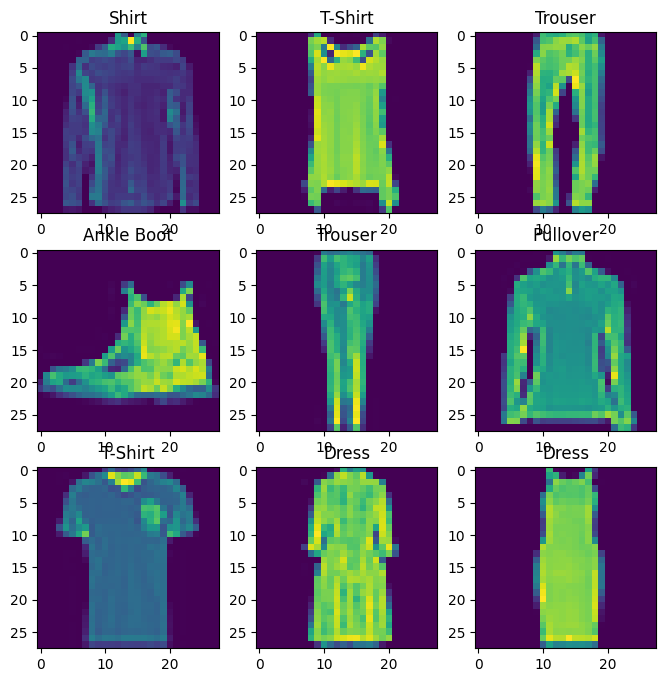

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
#This is a dictionary that maps class labels (0 to 9) to their corresponding class names (e.g., "T-Shirt," "Trouser," etc.). This mapping is useful for displaying the labels on the images.
figure=plt.figure(figsize=(8,8))

cols,rows=3,3
for i in range(1,rows*cols+1):
  sample_idx=torch.randint(len(training_data),size=(1,)).item()
  # This line generates a random index within the range of the training dataset's length to select a random sample.
  img,label=training_data[sample_idx]
  # This line retrieves the image and its corresponding label from the training dataset based on the randomly chosen index.
  figure.add_subplot(rows,cols,i)
  # This line adds a subplot to the figure. The i variable determines the position of the subplot in the grid.
  plt.title(labels_map[label])
  plt.imshow(img.squeeze())

## Batching

In [5]:
batch_size=64
# A batch size of 64 means that during training and testing, the data loader will load and process 64 samples at a time.

train_dataloader=DataLoader(training_data,batch_size=batch_size)
test_dataloader=DataLoader(testing_data,batch_size=batch_size)


## Model Creation

In [6]:
class NeuralNetwork(nn.Module): #

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    ## Init function is used to define the architecture blocks
    self.flatten = nn.Flatten() # 28 x 28 x1 - 764 x 1 vectpor
    self.layer1 = nn.Linear(28*28,512)
    self.layer2 = nn.Linear(512,256)
    self.layer3 = nn.Linear(256,10)

  def forward(self,x):
    x = self.flatten(x)
    x = self.layer1(x)
    x = F.relu(x) #F.sigmoid()
    x = self.layer2(x)
    x = F.sigmoid(x)
    x = self.layer3(x)
    return x

In [7]:
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

In [8]:
model=NeuralNetwork()
model.to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=10, bias=True)
)

In [9]:
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2)

In [10]:
def training_loop(dataloader,model,loss_fn,optimizer):
  model.train()

  #pass every batch of data to the model
  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    pred = model(X)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if batch % 100 == 0:
      print (f'loss : {loss.item()}')

In [11]:
def testing_loop(dataloader,model,loss_fn):
  model.eval()
  test_loss=0
  correct=0
  for X,y in dataloader:
    X=X.to(device)
    y=y.to(device)

    pred=model(X)
    correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss+=loss_fn(pred,y).item()
  test_loss=test_loss/len(dataloader)
  print(len(dataloader.dataset))
  accuracy=(correct/len(dataloader.dataset))*100
  print (f'Accuracy : {accuracy} with test error {test_loss}')

In [12]:
epochs = 5 #how many times you have to send data to the model

for t in range(epochs):
  training_loop(train_dataloader,model,loss_fn,optimizer)
  testing_loop(test_dataloader,model,loss_fn)
  print(f' ==================== EPOCH : {t} ============================')

loss : 2.332825183868408
loss : 2.2905850410461426
loss : 2.2688915729522705
loss : 2.2540323734283447
loss : 2.1909706592559814
loss : 2.165078639984131
loss : 2.0956015586853027
loss : 1.992627739906311
loss : 1.8720241785049438
loss : 1.7435935735702515
10000
Accuracy : 55.379999999999995 with test error 1.7092311162098197
 ==================== EPOCH : 0 ============================
loss : 1.7423704862594604
loss : 1.6454795598983765
loss : 1.462225317955017
loss : 1.4752142429351807
loss : 1.2896050214767456
loss : 1.3103013038635254
loss : 1.2534515857696533
loss : 1.172013521194458
loss : 1.1941152811050415
loss : 1.1231846809387207
10000
Accuracy : 64.03999999999999 with test error 1.0986952489348734
 ==================== EPOCH : 1 ============================
loss : 1.1662570238113403
loss : 1.1243075132369995
loss : 0.9543058276176453
loss : 1.085724949836731
loss : 0.9490207433700562
loss : 0.9976717829704285
loss : 0.9948585629463196
loss : 0.912405252456665
loss : 0.9432097